In [1]:
import collections
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from collections import OrderedDict
import pandas as pd
from pymongo import MongoClient

# Data collection

In [2]:
host = "localhost"
port = "27017"
username = "accretioadmin"
password = "adminaccretio&2017"
authSource = "admin"

In [ ]:
def _connect_mongo(db):
    if username and password:
        conn = MongoClient(host=host,
                            port=int(port),
                            username=username,
                            password=password,
                           authSource=authSource)
    else:
        conn = MongoClient(host, port)
        
    return conn[db]    


def read_mongo(db, collection, query={}):
    db = _connect_mongo(db=db)
    cursor = db[collection].find(query)
    df =  pd.DataFrame(list(cursor))
    return df

In [ ]:
df = read_mongo("connectTimeline", "post")
df = df[["_id","registrationNumber","body"]]
df["registrationNumber"] = df["registrationNumber"].astype(str)

In [ ]:
df = df.dropna()

In [ ]:
df = df[:300]

In [ ]:
df.shape

# Data cleaning

In [ ]:
import re
import emoji
import spacy
from spacy_lefff import LefffLemmatizer, POSTagger
from spacy.language import Language

In [ ]:
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

final_stopwords_list = list(fr_stop) + list(en_stop)

In [ ]:
import re
import emoji

In [ ]:
def remove_emoji(string):
    return emoji.get_emoji_regexp().sub(u'', string)

In [ ]:
def custom_stopwords(text):
    #common_words
    text = " ".join([w for w in text.split() if w.lower() not in final_stopwords_list])
    #HTML TAGS
    text = re.sub(r'<.*?>', '', text)
    #links
    text = re.sub("https?:\/\/.*[\r\n]*", "", text)  
    #alpha_numeric
    text = re.sub(r'[^a-zA-Z0-9 àâäèéêëîïôœùûüÿçÀÂÄÈÉÊËÎÏÔ\'ŒÙÛÜŸÇ]+', '', text)
    # remove emojis
    text = remove_emoji(text)
    #remove duplicate space
    clear_text = " ".join(text.split())
    
    return clear_text

In [ ]:
df["body"] = df["body"].apply(custom_stopwords)

In [ ]:
df = df[df['body'].map(len)>1]

### POS and Lemmatization

In [ ]:
@Language.factory('french_lemmatizer')
def create_lemmatizer(nlp, name):
    return LefffLemmatizer()

nlp = spacy.load('fr_core_news_md')

nlp.add_pipe('french_lemmatizer', name='lefff')     

In [ ]:
def replace_lemma(text):    
    doc = nlp(text)
    for d in doc:
        if(d.pos_ != "PROPN" and d.pos_ != "NUM" and d.pos_ != "AUX" and d.pos_ !='DET'):
            text = text.replace(d.text,  d.lemma_ )
        else:
            text = text.replace(d.text, '')
    return text   

In [ ]:
df["body"] = df["body"].apply(replace_lemma)

In [ ]:
# # don't show in rapport
# df["body"] = df["body"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word.lower() not in final_stopwords_list))

In [ ]:
# # don't show in rapport
# df["body"] = df["body"].apply(lambda text :re.sub(' +', ' ', text))

In [ ]:
df.shape

# Embedding :  a clustering of word

In [ ]:
data = df.body.values

In [ ]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

In [ ]:
len(embeddings[7] )

In [ ]:
embeddings[:3]  # a vector for each post (document)

In [ ]:
len(embeddings)

In [ ]:
len(embeddings[1]) 

# Dimensionality reduction : umap

In [ ]:
# umap is a  dimensionality reduction algorithm
umap_embeddings = umap.UMAP(n_neighbors=2, 
                            n_components=3, 
                            metric='cosine').fit_transform(embeddings)

In [ ]:
len(umap_embeddings)

# Modeling

In [ ]:
len(umap_embeddings[1])  # n_components

# Clustering

In [ ]:
cluster = hdbscan.HDBSCAN(min_cluster_size=17,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)


In [ ]:
len(list(set(cluster.labels_)))

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=2, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

In [ ]:
result.head()

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels,  cmap='hsv_r')
plt.colorbar()

# Topic per document

In [ ]:
def order_people(ch):
    l = ch.split()
    temp = l[:]
    l.sort(key=lambda x:temp.count(x), reverse= True)
    return list(dict.fromkeys(l))  

In [ ]:
# create a single document for each cluster of documents:
#all documents in a single cluster are considered as one documments

docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df["posts"] = df["_id"].astype("str").values
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join, 'posts': ' '.join})#
# concatenate docs with same topic (with space) ---->  'Doc': ' '.join
docs_per_topic["posts"] =docs_per_topic["posts"].apply(lambda x: order_people(x))

In [ ]:
docs_per_topic["Topic"] = docs_per_topic["Topic"].astype(str)

len(docs_per_topic[docs_per_topic["Topic"] == str(-1)]["posts"][0])

# TF-IDF ==> to extract relevant words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words = final_stopwords_list).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [ ]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [ ]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, docs, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    topic_sizes = extract_topic_sizes(docs)
    # sort the dict to get the HOT topics ordered
    top_n_words = OrderedDict(top_n_words)
    key_order = list(topic_sizes["Topic"].values)    
    for k in key_order:
        top_n_words.move_to_end(k)
    top_n_words = dict(top_n_words)    
    return top_n_words
    

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, docs_df, n=10)
#topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

In [ ]:
def word_clouds(top_words):
    my_dict = dict()
    word_cloud = list()
    for topic, value in top_words.items():
        words = list()
        for i in value:
            my_dict["text"] = i[0]
            my_dict["weight"] = i[1]                       
            words.append(my_dict.copy())
        posts = list(docs_per_topic[docs_per_topic["Topic"] == str(topic)]["posts"])[0]    
        words.append({"posts":posts})    
        print(words)  
        word_cloud.append(words)
    return word_cloud

In [ ]:
word_cloud = word_clouds(top_n_words)

In [ ]:
word_cloud

In [ ]:
import datetime

current_date = datetime.date.today().isoformat()

In [ ]:
current_date = {"current_date" : current_date}
top_n_words.append(current_date)

In [ ]:
#df["body"] = df["body"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word.lower() not in final_stopwords_list))


/home/emna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


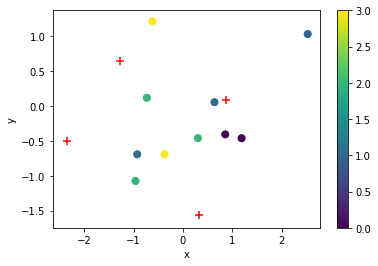

In [3]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.randn(10)
y = np.random.randn(10)
Cluster = np.array([0, 1, 1, 1, 3, 2, 2, 3, 0, 2])    # Labels of cluster 0 to 3
centers = np.random.randn(4, 2) 

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y,c=Cluster,s=50)
for i,j in centers:
    ax.scatter(i,j,s=50,c='red',marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)

fig.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(df['Feature1'])
y = np.array(df['Feature2'])
z = np.array(df['Feature3'])

ax.scatter(x,y,z, marker="s", c=df["Cluster"], s=40, cmap="RdBu")

plt.show()

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels,  cmap='hsv_r')
plt.colorbar()